In [1]:
%run state_tracker.ipynb
%run elder.ipynb
%run dagger_agent.ipynb
import matplotlib.pyplot as plt
import csv

In [2]:
USE_USERSIM = True
WARMUP_MEM = 40000

NUM_EP_ITER = 100 #10000, 12000
#TRAIN_FREQ = 100 #100, 50
NUM_ITER = 50
MAX_ROUND_NUM = 25 #20, 15, 10
#SUCCESS_RATE_THRESHOLD = 0.5 #0.3, 0.7, 0.4, 0.5

user = Elder()
dagger_agent = DAGGER_Agent()
state_tracker = StateTracker()

In [3]:
def run_round(state, turn_num, c, episode, warmup=False):
    # 1) Agent takes action given state of the world, i.e the action of elder and the helper's state
    agent_input = dagger_agent.prep_input(state[0], state[1][1])
    expert_output, exp_flag = dagger_agent.get_expert_action(agent_input, state[0], state[1][1])
    agent_output = dagger_agent.get_action(agent_input, state[0], state[1][1], warmup)
    # 2) Update state tracker with the agent's action
    state_tracker.update_state_agent(agent_output)
    # 3) User takes action given agent action
    feature_input = user.prep_input()
    user_output = user.elder(feature_input)
    # 4) Update state tracker with user action
    state_tracker.update_state_user(user_output)
    # 5) Get next state and add experience
    next_state = [state_tracker.get_state_user(), state_tracker.get_state_agent()]
    _,_, done, success, forbidden = state_tracker.get_state_agent()
    
    if exp_flag:
        #print('state:', state[1][1])
        c += 1
        if ((agent_output['action_out'].item()==2 and state[1][1][0][1]==1 and state[1][1][1][1]==1) or
            (agent_output['action_out'].item()==2 and state[1][1][0][1]==1 and state[1][1][1][1]==2)):
            expert_output={}
            expert_output['action_out']=torch.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]).to(device)
            #print('here')
            #print(expert_output)
        
        if turn_num%2==0:
            dagger_agent.add_experience(state, agent_output, expert_output, done, success)
            dagger_agent.num_samples_epoch += 1
        
        
        if c <= 6 and episode <= 5:
            print('episode:',episode, 'user_output:', state[0]['action_out'].item(), 
                 'agent_state:', state[1][1], 'agent_output:', agent_output['action_out'].item(),
                 'expert_output:', torch.argmax(expert_output['action_out']).item(),
                 )
            
    if not exp_flag:
        turn_num = turn_num - 1
        #done = True
        
        
    return next_state, done, success, turn_num, c

def warmup_run():
    """
    Runs the warmup stage of training which is used to fill the agents memory.
    The agent uses it's rule-based policy to make actions. The agent's memory is filled as this runs.
    Loop terminates when the size of the memory is equal to WARMUP_MEM or when the memory buffer is full.
    """

    print('Warmup Started...')
    total_step = 0
    while (total_step < WARMUP_MEM) and (not dqn_agent.is_memory_full()):
    #while total_step != WARMUP_MEM:
        # Reset episode
        episode_reset()
        done = False
        round_num = 0
        # Get initial state from state tracker
        state = [state_tracker.get_state_user(), state_tracker.get_state_agent()]
        while not done:
            next_state, _, done, _, _, _ = run_round(state, round_num, warmup=True)
            total_step += 1
            state = next_state
            round_num += 1
            if round_num >= MAX_ROUND_NUM: 
                done = True

    print('...Warmup Ended')


def dagger_run():
    """
    Runs the loop that trains the agent. Training of the agent's neural network occurs every episode that
    TRAIN_FREQ is a multiple of. Terminates when the episode reaches NUM_EP_TRAIN.

    """

    print('Training Started...')
    
    success_rate_best = 0.0
    epoch_turns = []
    epoch_s_rate = []
    epoch_losses = [None] # each element is the loss of one epoch
    ep_start_train = []
    
    for iteration in range(NUM_ITER):
        if dagger_agent.is_memory_full():
            dagger_agent.empty_memory()
            
        iteration += 1
        episode = 0
        period_success_total = 0
        period_turns_total = 0
        dagger_agent.model.eval()
        while episode < NUM_EP_ITER:
            episode_reset()
            episode += 1
            done = False
            round_num = 0
            turn_num = 0
            c = 0
            state = [state_tracker.get_state_user(), state_tracker.get_state_agent()]

        
            while not done:                
                next_state, done, success, turn_num, c = run_round(state, round_num, c, episode, warmup=False)
                state = next_state
                round_num += 1
                turn_num += 1
                #print(round_num, end="-")
                if round_num >= MAX_ROUND_NUM: 
                    done = True
                    
            period_success_total += success
            #period_turns_total += c
            period_turns_total += turn_num
                    
        #print('not eligible episodes:', turn_num)  
        success_rate = period_success_total / (NUM_EP_ITER)
        avg_turns = period_turns_total / (NUM_EP_ITER)
        epoch_s_rate.append(period_success_total)
        epoch_turns.append(period_turns_total)
        
        
        print('success_rate={} avg_turns={} prev_best_success_rate={}'.format(
            success_rate, avg_turns, success_rate_best))               
            

        print('\niteration=', iteration, ' num_samples=',dagger_agent.num_samples_epoch,
              ' mem_ind=', dagger_agent.memory_index)



        # Update current best success rate
        if success_rate > success_rate_best:
            print('Episode: {} NEW BEST SUCCESS RATE: {}'.format(episode, success_rate,))
            success_rate_best = success_rate
        
            #dagger_agent.save_weights()


        # Train

        ep_start_train.append(episode)
        batchlosses_of_epoch = dagger_agent.train()
        dagger_agent.save_weights()
        dagger_agent.model_num += 1

        dagger_agent.num_samples_epoch = 0
        if not (len( batchlosses_of_epoch) > 0):
            epoch_losses.append(epoch_losses[-1])
        elif len( batchlosses_of_epoch) > 0:
            avgloss_of_epoch = np.mean(np.asarray(batchlosses_of_epoch))
            epoch_losses.append(avgloss_of_epoch)

        if iteration % (5) == 0 and iteration != 0:
            fig, ax_left = plt.subplots()
            ax_right = ax_left.twinx()

            ax_left.plot(np.arange(1,len(epoch_turns)+1), epoch_turns, 'g')
            ax_right.plot(np.arange(1,len(epoch_turns)+1), epoch_s_rate, 'r')
            ax_left.set_xlabel('Epoch')
            ax_left.set_ylabel('Average Turns')
            ax_right.set_ylabel('Success Rate')

            fig1, ax_left1 = plt.subplots()
            ax_right1 = ax_left1.twinx()
            ax_left1.plot(np.arange(len(epoch_losses)), epoch_losses, 'g')
            ax_left1.set_xlabel('Epoch')
            ax_left1.set_ylabel('Training Loss')
            plt.show()
            
          
        
    print('...Training Ended')
    print('Best Success Rate is: {}'.format(success_rate_best))
    
    return epoch_losses, epoch_turns, epoch_s_rate


def episode_reset():
    """
    Resets the episode/conversation in the warmup and training loops.
    Called in warmup and train to reset the state tracker, user and agent. Also get's the initial user action.

    """
    # First reset the state tracker
    state_tracker.reset()
    # Then pick an init user action
    user_output = user.reset()
    user_output = user.transform_da(user_output, init=True)
    # And update state tracker
    state_tracker.update_state_user(user_output)

In [4]:
dagger_agent.memory_index

0

Training Started...
episode: 1 user_output: 1 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 1 user_output: 1 agent_state: [['cup', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 1 user_output: 1 agent_state: [['cup', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 1 user_output: 1 agent_state: [['cup', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 1 user_output: 1 agent_state: [['cup', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 1 user_output: 1 agent_state: [['cup', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 2 user_output: 6 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 2 user_output: 1 agent_state: [['ball', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 2 user_output: 1 agent_state: [['ball', 1], [None, 0], [None, 0]] agent_output: 1 expert_output: 2
episode: 2 user_o

episode: 4 user_output: 1 agent_state: [['cup', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 5 user_output: 1 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 5 user_output: 1 agent_state: [['ball', 1], ['c1', 1], [None, 0]] agent_output: 2 expert_output: 4
episode: 5 user_output: 2 agent_state: [['ball', 1], ['c1', 1], [None, 0]] agent_output: 1 expert_output: 4
episode: 5 user_output: 1 agent_state: [['ball', 1], ['c1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 5 user_output: 1 agent_state: [['ball', 1], ['c1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 5 user_output: 1 agent_state: [['ball', 1], ['c1', 1], [None, 0]] agent_output: 6 expert_output: 6
success_rate=0.0 avg_turns=24.01 prev_best_success_rate=0.0

iteration= 5  num_samples= 162  mem_ind= 1670
num_batches= 52
Training loss: 24.503949882767092


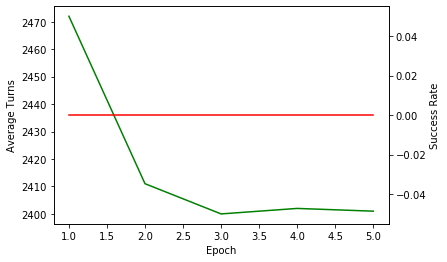

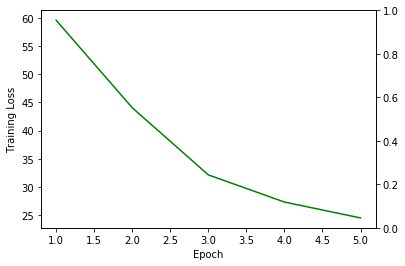

episode: 1 user_output: 5 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 1 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 1 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 1 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 1 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 1 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 2 user_output: 1 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 2 user_output: 1 agent_state: [['cup', 1], ['d1', 1], [None, 0]] agent_output: 2 expert_output: 4
episode: 2 user_output: 2 agent_state: [['cup', 1], ['d1', 1], [None, 0]] agent_output: 4 expert_output: 4
episode: 2 user_output: 6 agent_st

episode: 2 user_output: 4 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 2 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 2 expert_output: 4
episode: 2 user_output: 2 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 4 expert_output: 4
episode: 2 user_output: 6 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 1 expert_output: 5
episode: 2 user_output: 1 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 6 expert_output: 6
episode: 3 user_output: 1 agent_state: [[None, 0], [None, 0], [None, 0]] agent_output: 1 expert_output: 1
episode: 3 user_output: 1 agent_state: [['ball', 1], ['d1', 2], [None, 0]] agent_output: 2 expert_output: 4
episode: 3 user_output: 2 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 4 expert_output: 4
episode: 3 user_output: 6 agent_state: [['ball', 1], ['d1', 1], [None, 0]] agent_output: 1 expert_output: 5
episode: 3 user_output: 1 agent_

In [ ]:
epoch_losses, epoch_turns, epoch_s_rate = dagger_run()
with open('../results/curves_file.csv', mode='w') as curves_file:
    file_writer = csv.writer(curves_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    file_writer.writerow(['epoch_losses', epoch_losses])
    file_writer.writerow(['epoch_turns', epoch_turns])
    file_writer.writerow(['epoch_s_rate', epoch_s_rate])